In [8]:
from google.cloud import storage
import argparse
import gzip
import os
import sys
import time
from multiprocessing import Pool

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from utils import gcs_utils as gcs
from utils import model_and_evaluate_cluster as ev
import urllib.parse
import urllib.request

import io 

import importlib
import hdbscan
import networkx as nx 
import pickle

import obonet

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf



# Model Comparison Graphs

In [12]:
# Just go to our results spreadsheet "Model Outputs" tab. File > download > TSV
modeloutput = pd.read_csv('Results - Model Outputs.tsv', 
                          sep='\t',
                         header=3, thousands=',')

# Clean up
    # Remove NA
    # Remove "Do not use" embeddings (CurveNet)
    # Select just a few cols

modeloutput = modeloutput[~modeloutput.goodplace_pairs_pct.isna()]
modeloutput = modeloutput[~modeloutput.embedding.str.contains('DO NOT USE')]
modeloutput = modeloutput[['id', 'model', 'embedding', 'largest_clus', 
                           'clusters', 'silhouette', 'db',
                           'noise_pct', 'func_sim', 
                           'goodplace_pairs_pct', 'goodplace_clusters_pct',
                           'metrics_coverage_pct']]

In [13]:
modeloutput.head()

,id,model,embedding,largest_clus,clusters,silhouette,db,noise_pct,func_sim,goodplace_pairs_pct,goodplace_clusters_pct,metrics_coverage_pct
2,A2EP,DBSCAN,SeqVec,691.0,1534.0,0.37,0.75,0.6299,0.3943,0.6078,0.4437,0.6532
4,A1EP,DBSCAN,DeepFold,4571.0,1221.0,0.00,0.93,0.5135,0.0508,0.0372,0.5711,0.0241
6,A3EP,DBSCAN,Structure LSTM + SeqVec,232.0,714.0,0.55,0.48,0.8792,0.7392,0.8735,0.5855,0.8043
10,B2EP,HDBSCAN,SeqVec,416.0,741.0,0.23,1.36,0.5555,0.5021,0.5686,0.2363,0.8117
11,B2EPA,HDBSCAN,SeqVec,401.0,314.0,0.32,1.10,0.6898,0.4601,0.4423,0.3131,0.6491


In [515]:
data=modeloutput
x="clusters"
y="noise_pct"

X = sm.add_constant(modeloutput[x])
Y = modeloutput[y]

est = sm.OLS(Y, sm.add_constant(X))
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:              noise_pct   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     5.916
Date:                Sun, 05 Dec 2021   Prob (F-statistic):             0.0263
Time:                        19:06:40   Log-Likelihood:                 15.369
No. Observations:                  19   AIC:                            -26.74
Df Residuals:                      17   BIC:                            -24.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7120      0.036     19.692      0.0

/Users/haeranglee/opt/anaconda3/envs/pss/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


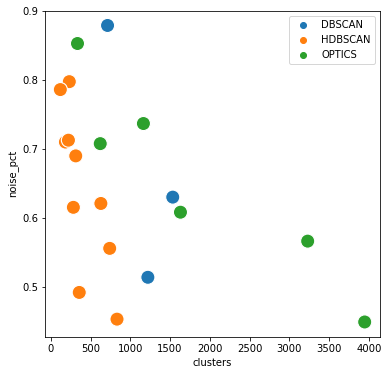

In [11]:
data=modeloutput
x="clusters"
y="noise_pct"
hue='model'

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                hue=hue,
                s=200
                )
ax.legend(loc='upper right')

We control the noise level. So put that into X. Let's see what affect it has on structural similarity.

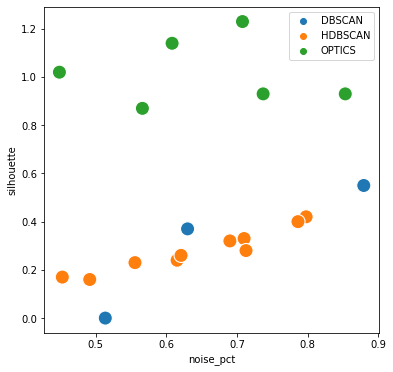

In [14]:
data=modeloutput
x="noise_pct"
y="silhouette"
hue='model'

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                hue=hue,
                s=200
                )
ax.legend(loc='upper right')

Then we want to know if we are giving up on the things that MATTER

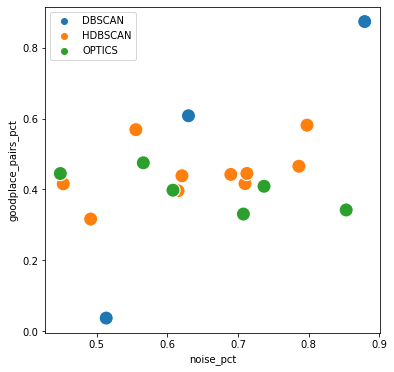

In [34]:
data=modeloutput
x="noise_pct"
y="goodplace_pairs_pct"
hue='model'

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                hue=hue,
                s=200
                )
ax.legend(loc='best')

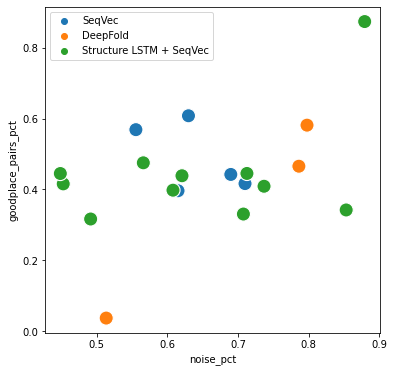

In [33]:
data=modeloutput
x="noise_pct"
y="goodplace_pairs_pct"
hue='embedding'

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                hue=hue,
                s=200
                )
ax.legend(loc='best')

In [27]:
mod = smf.ols("goodplace_pairs_pct ~ noise_pct + embedding", data=modeloutput).fit()
print(mod.summary())

                             OLS Regression Results                            
Dep. Variable:     goodplace_pairs_pct   R-squared:                       0.285
Model:                             OLS   Adj. R-squared:                  0.142
Method:                  Least Squares   F-statistic:                     1.991
Date:                 Sun, 05 Dec 2021   Prob (F-statistic):              0.159
Time:                         19:25:49   Log-Likelihood:                 11.589
No. Observations:                   19   AIC:                            -15.18
Df Residuals:                       15   BIC:                            -11.40
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

/Users/haeranglee/opt/anaconda3/envs/pss/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [25]:
mod = smf.ols("goodplace_pairs_pct ~ noise_pct + model", data=modeloutput).fit()
print(mod.summary())

                             OLS Regression Results                            
Dep. Variable:     goodplace_pairs_pct   R-squared:                       0.225
Model:                             OLS   Adj. R-squared:                  0.070
Method:                  Least Squares   F-statistic:                     1.452
Date:                 Sun, 05 Dec 2021   Prob (F-statistic):              0.267
Time:                         19:23:52   Log-Likelihood:                 10.828
No. Observations:                   19   AIC:                            -13.66
Df Residuals:                       15   BIC:                            -9.877
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1553   

In [28]:
modeloutput.columns

Index(['id', 'model', 'embedding', 'largest_clus', 'clusters', 'silhouette',
       'db', 'noise_pct', 'func_sim', 'goodplace_pairs_pct',
       'goodplace_clusters_pct', 'metrics_coverage_pct'],
      dtype='object')

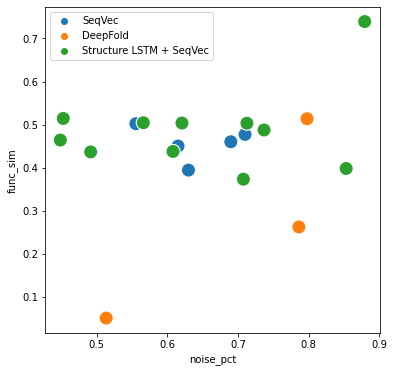

In [32]:
data=modeloutput
x="noise_pct"
y="func_sim"
hue='embedding'

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                hue=hue,
                s=200
                )
ax.legend(loc='best')

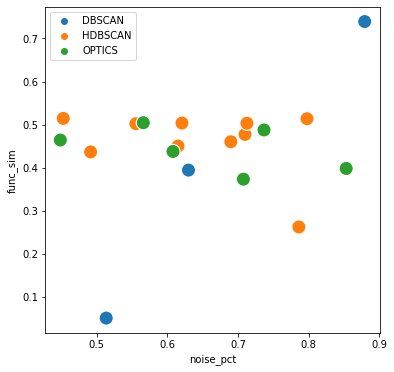

In [31]:
data=modeloutput
x="noise_pct"
y="func_sim"
hue='model'

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                hue=hue,
                s=200
                )
ax.legend(loc='best')

In [35]:
mod = smf.ols("goodplace_pairs_pct ~ func_sim + model", data=modeloutput).fit()
print(mod.summary())

                             OLS Regression Results                            
Dep. Variable:     goodplace_pairs_pct   R-squared:                       0.748
Model:                             OLS   Adj. R-squared:                  0.698
Method:                  Least Squares   F-statistic:                     14.88
Date:                 Sun, 05 Dec 2021   Prob (F-statistic):           9.13e-05
Time:                         19:33:49   Log-Likelihood:                 21.517
No. Observations:                   19   AIC:                            -35.03
Df Residuals:                       15   BIC:                            -31.26
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0992   

/Users/haeranglee/opt/anaconda3/envs/pss/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [36]:
mod = smf.ols("goodplace_pairs_pct ~ func_sim + embedding", data=modeloutput).fit()
print(mod.summary())

                             OLS Regression Results                            
Dep. Variable:     goodplace_pairs_pct   R-squared:                       0.768
Model:                             OLS   Adj. R-squared:                  0.722
Method:                  Least Squares   F-statistic:                     16.55
Date:                 Sun, 05 Dec 2021   Prob (F-statistic):           5.05e-05
Time:                         19:34:10   Log-Likelihood:                 22.283
No. Observations:                   19   AIC:                            -36.57
Df Residuals:                       15   BIC:                            -32.79
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

/Users/haeranglee/opt/anaconda3/envs/pss/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
